In [1]:
import os
import random
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import cv2
import numpy as np
import torch
from ultralytics import YOLO

import models
import utils
importlib.reload(models)
importlib.reload(utils)

import sys
import contextlib

from PIL import Image
from torchvision import transforms

In [2]:
%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загрузим модель для определения landmarks
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    model_FaceAlignment = models.LandmarksNet()
    model_FaceAlignment.load_state_dict(torch.load("./weights/best_model_FaceAligment.pth"))
    model_FaceAlignment.to(device)
    model_FaceAlignment.eval()

# Загрузим детектор
detector_model = YOLO("./weights/yolov8s-face-lindevs.pt")

# Загрузим модель для классификации
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    model_ArcFace = models.ArcFace_model()
    model_ArcFace.load_state_dict(torch.load("./weights/best_model_ArcFace.pth"))
    model_ArcFace.to(device)
    model_ArcFace.eval()

In [4]:
img_dir = r'.\img_test'

# Получаем список изображений
img_list = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Выбираем случайное изображение или задаем свое
img_name = random.choice(img_list)
img_path = os.path.join(img_dir, img_name)

image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

[Scaled bbox] Width: 196, Height: 284


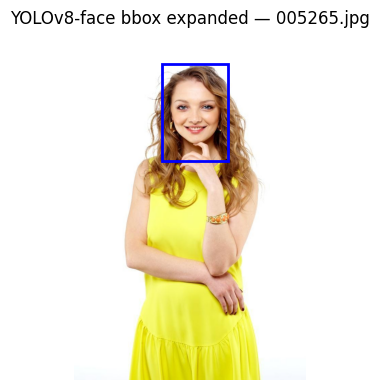

In [5]:
bbox = utils.get_face_bbox(image_rgb, detector_model=detector_model, scale_w=0.2, scale_h=0.3, show=True, img_name=img_name)

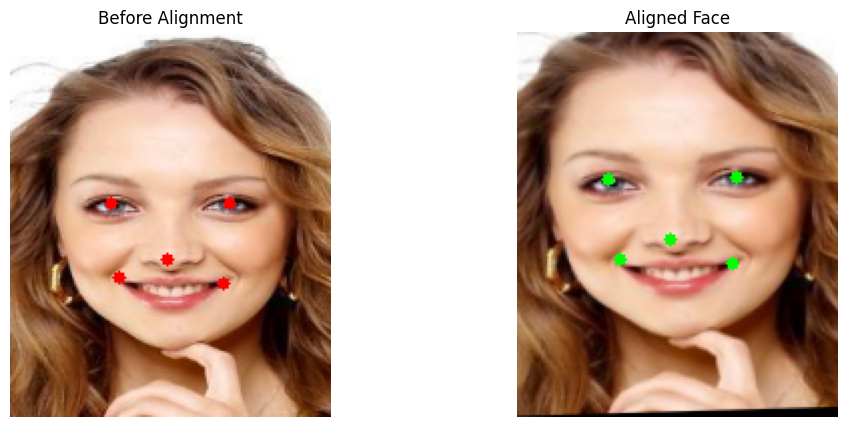

In [6]:
aligned_face = utils.predict_and_align(
        image_rgb=image_rgb,
        bbox=bbox,
        model=model_FaceAlignment,
        template=models.TEMPLATE,
        show=True
    )

In [7]:
image_pil = Image.fromarray(aligned_face)  # Преобразуем в PIL.Image

# Трансформация
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(350),
    transforms.Pad((0, 0, 0, 50)),       # Padding снизу
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# Применяем
input_tensor = transform(image_pil).unsqueeze(0).to(device)  # [1, 3, 224, 224]

model_ArcFace.eval()
with torch.no_grad():
    logits = model_ArcFace(input_tensor)  # Предсказание без label
    probs = torch.softmax(logits, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()

In [13]:
# Загружаем валидируемую таблицу
df_val = pd.read_csv(r".\val.csv")

def get_gt_label(img_name, df):
    """
    Возвращает GT метку (_id) по имени изображения.
    """
    row = df[df["img"] == img_name]
    if row.empty:
        raise ValueError(f"Изображение '{img_name}' не найдено в val.csv")
    return int(row["_id"].values[0])

confidence = probs[0][pred_class].item()
gt_label = get_gt_label(img_name, df_val)

print(f"GT метка: {gt_label}")
print(f"Класс: {pred_class} — уверенность: {confidence:.4f}")
print("✅ Совпадение!" if gt_label == pred_class else "❌ Не совпадает!")


GT метка: 47
Класс: 47 — уверенность: 0.0000
✅ Совпадение!


In [9]:
pred_class, confidence, gt_label = utils.predict_identity(aligned_face, img_name, model_ArcFace, df_val)

print(f"GT метка: {gt_label}")
print(f"Предсказано: {pred_class}, уверенность: {confidence:.4f}")
print("✅ Совпадение!" if gt_label == pred_class else "❌ Не совпадает!")

GT метка: 0
Предсказано: 0, уверенность: 1.0000
✅ Совпадение!


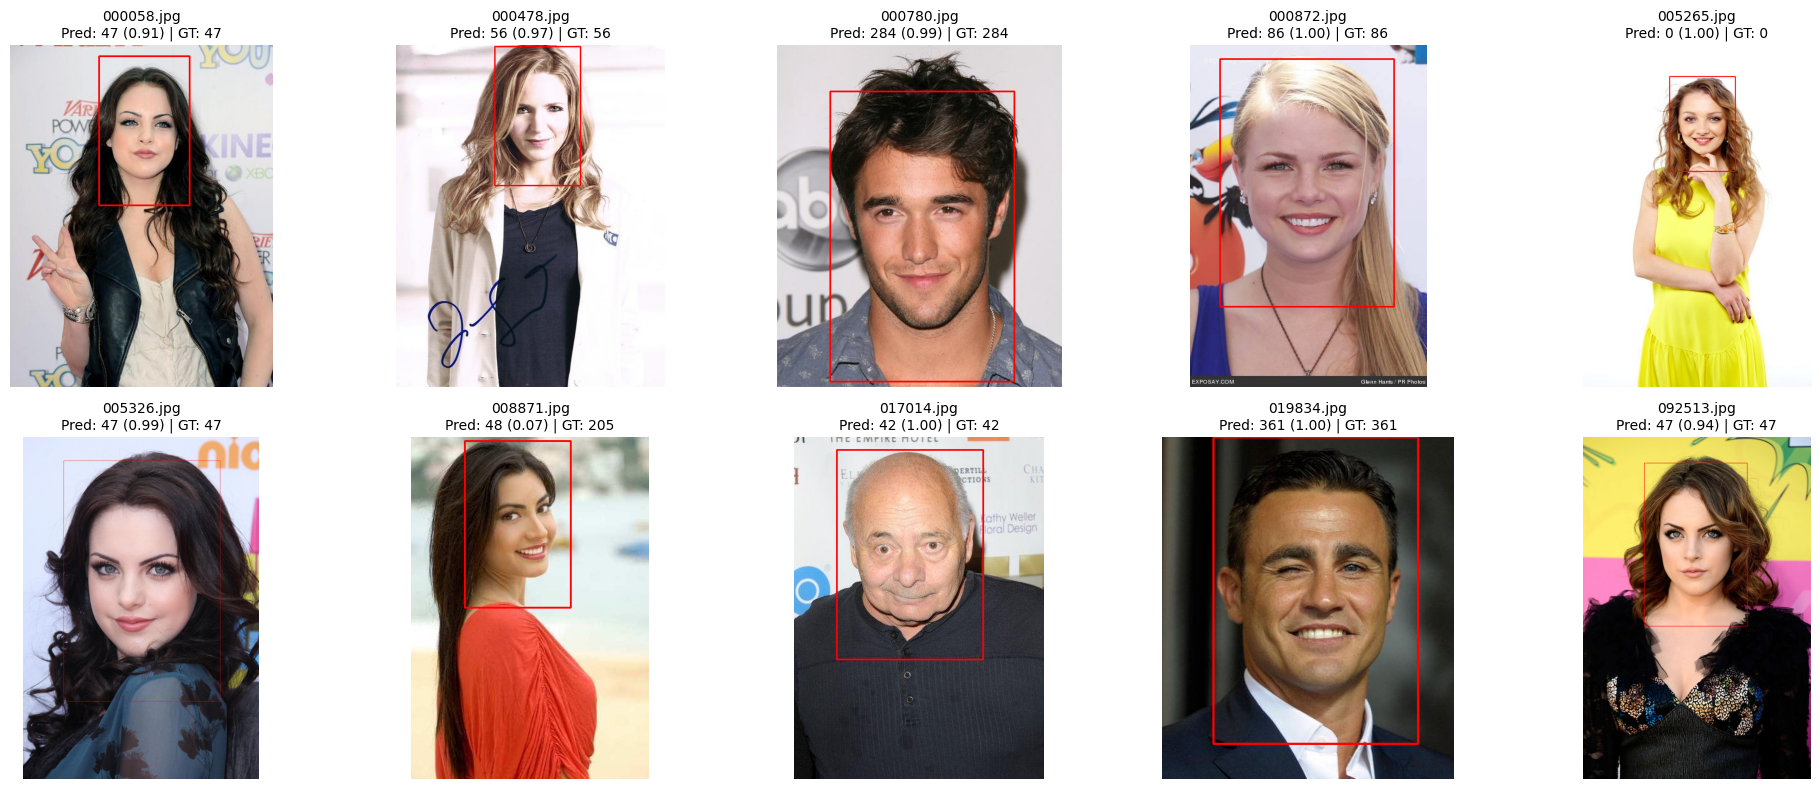

In [10]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Папка с изображениями
img_dir = r'.\img_test'

# Получаем список изображений
img_list = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Настройка сетки 5x2
num_cols = 5
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 8))
axs = axs.flatten()

# Обработка и отображение изображений
for i, img_name in enumerate(img_list[:num_cols * num_rows]):
    img_path = os.path.join(img_dir, img_name)

    # Чтение и конвертация изображения
    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    try:
        # Получение bbox
        bbox = utils.get_face_bbox(image_rgb, detector_model=detector_model, scale_w=0.2, scale_h=0.3, show=False)

        # Выравнивание лица
        aligned_face = utils.predict_and_align(
            image_rgb=image_rgb,
            bbox=bbox,
            model=model_FaceAlignment,
            template=models.TEMPLATE,
            show=False
        )

        # Предсказание личности
        pred_class, confidence, gt_label = utils.predict_identity(aligned_face, img_name, model_ArcFace, df_val)

        # Отрисовка bbox
        image_with_bbox = image_rgb.copy()
        x1, y1, x2, y2 = map(int, bbox)
        cv2.rectangle(image_with_bbox, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Подпись
        title = f"{img_name}\nPred: {pred_class} ({confidence:.2f}) | GT: {gt_label}"

        # Отображение
        axs[i].imshow(image_with_bbox)
        axs[i].set_title(title, fontsize=10)
        axs[i].axis('off')

    except Exception as e:
        axs[i].set_title(f"{img_name}\nError: {str(e)}", fontsize=10)
        axs[i].axis('off')

# Убираем лишние подграфики, если изображений меньше чем 5x2
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


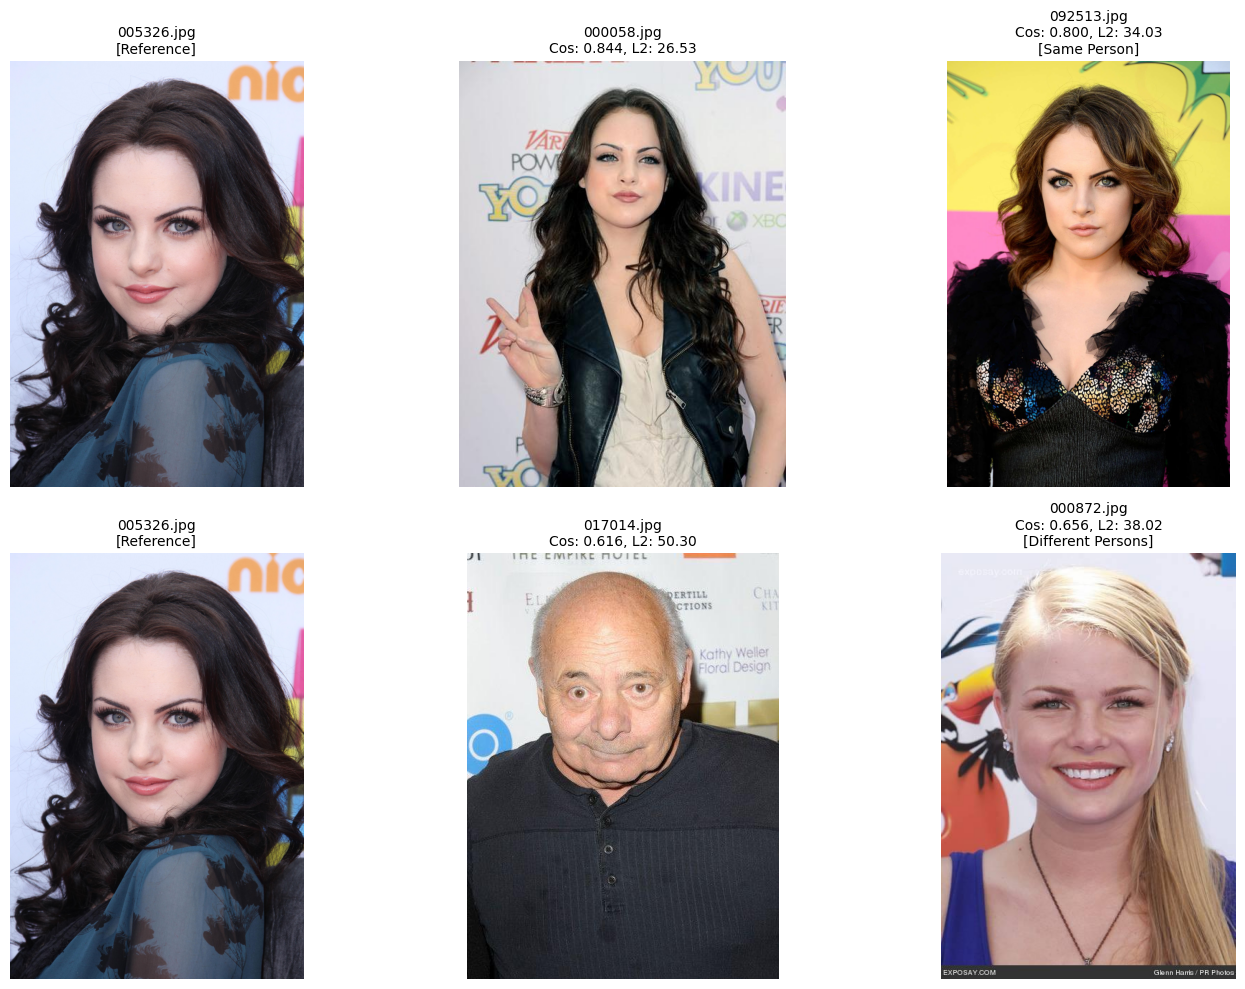

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

# Путь к изображениям
img_dir = r'.\img_test'

# Пары для сравнения: (имя1, имя2, описание)
pairs = [
    ('005326.jpg', '000058.jpg', '092513.jpg', 'Same Person'),
    ('005326.jpg', '017014.jpg', '000872.jpg', 'Different Persons')
]

# Функция: получить RGB и эмбеддинг
def process_image(img_name):
    img_path = os.path.join(img_dir, img_name)
    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    bbox = utils.get_face_bbox(image_rgb, detector_model=detector_model, scale_w=0.2, scale_h=0.3, show=False)
    aligned_face = utils.predict_and_align(
        image_rgb=image_rgb,
        bbox=bbox,
        model=model_FaceAlignment,
        template=models.TEMPLATE,
        show=False
    )

    # Подготовка для ArcFace
    aligned_face = cv2.resize(aligned_face, (112, 112))
    aligned_face = aligned_face.astype(np.float32) / 255.0
    aligned_face = torch.from_numpy(aligned_face).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)
    aligned_face = aligned_face.to(torch.float32).to(next(model_ArcFace.parameters()).device)

    with torch.no_grad():
        embedding = model_ArcFace(aligned_face).cpu().numpy().flatten()

    return image_rgb, embedding

def compute_metrics(emb1, emb2):
    emb1_norm = emb1 / norm(emb1)
    emb2_norm = emb2 / norm(emb2)
    cos_sim = np.dot(emb1_norm, emb2_norm)
    l2_dist = norm(emb1 - emb2)
    return cos_sim, l2_dist

# Визуализация
fig, axs = plt.subplots(len(pairs), 3, figsize=(15, 5 * len(pairs)))

if len(pairs) == 1:
    axs = [axs]

for row_idx, (img1, img2, img3, label) in enumerate(pairs):
    try:
        # Получаем изображения и эмбеддинги
        img_rgb1, emb1 = process_image(img1)
        img_rgb2, emb2 = process_image(img2)
        img_rgb3, emb3 = process_image(img3)

        # Метрики img1 ↔ img2 и img1 ↔ img3
        cos12, l2_12 = compute_metrics(emb1, emb2)
        cos13, l2_13 = compute_metrics(emb1, emb3)

        # Подписи
        titles = [
            f"{img1}\n[Reference]",
            f"{img2}\nCos: {cos12:.3f}, L2: {l2_12:.2f}",
            f"{img3}\nCos: {cos13:.3f}, L2: {l2_13:.2f}\n[{label}]"
        ]

        # Отображение
        for col_idx, (img, title) in enumerate(zip([img_rgb1, img_rgb2, img_rgb3], titles)):
            axs[row_idx][col_idx].imshow(img)
            axs[row_idx][col_idx].set_title(title, fontsize=10)
            axs[row_idx][col_idx].axis('off')

    except Exception as e:
        for col in range(3):
            axs[row_idx][col].set_title(f"Error: {str(e)}", fontsize=10)
            axs[row_idx][col].axis('off')

plt.tight_layout()
plt.savefig("triplet_comparison_fixed.png")
plt.show()